# Yahoo Finance Ticker Verification Tool

This notebook will:
1. Read a CSV file containing stock ticker symbols
2. Generate possible Yahoo Finance ticker formats
3. **Verify which tickers actually exist** on Yahoo Finance
4. Create a new CSV with the original ticker and the verified Yahoo Finance ticker

## 1. Install Required Packages

In [38]:
# Install required packages if not already installed
!pip install pandas requests beautifulsoup4 tqdm

## 2. Import Libraries and Define Functions

In [39]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random
from tqdm.notebook import tqdm
import re

In [40]:
# Define common exchange suffixes for Yahoo Finance
EXCHANGE_SUFFIXES = [
    {'suffix': '', 'description': 'US Markets (default)'},
    {'suffix': '.ST', 'description': 'Stockholm Stock Exchange'},
    {'suffix': '.CO', 'description': 'Copenhagen Stock Exchange'},
    {'suffix': '.OL', 'description': 'Oslo Stock Exchange'},
    {'suffix': '.HE', 'description': 'Helsinki Stock Exchange'},
    {'suffix': '.DE', 'description': 'German Stock Exchange'},
    {'suffix': '.L', 'description': 'London Stock Exchange'},
    {'suffix': '.PA', 'description': 'Paris Stock Exchange'},
    {'suffix': '.MI', 'description': 'Milan Stock Exchange'},
    {'suffix': '.MC', 'description': 'Madrid Stock Exchange'},
    {'suffix': '.TO', 'description': 'Toronto Stock Exchange'},
    {'suffix': '.AX', 'description': 'Australian Stock Exchange'},
    {'suffix': '.NZ', 'description': 'New Zealand Stock Exchange'},
    {'suffix': '.HK', 'description': 'Hong Kong Stock Exchange'},
    {'suffix': '.TW', 'description': 'Taiwan Stock Exchange'},
    {'suffix': '.KS', 'description': 'Korea Stock Exchange'},
    {'suffix': '.T', 'description': 'Tokyo Stock Exchange'}
]

In [41]:
def clean_ticker(ticker):
    """
    Clean ticker symbol for Yahoo Finance format
    """
    # Replace spaces with hyphens
    ticker = ticker.replace(' ', '-')
    return ticker

In [42]:
def verify_yahoo_ticker(ticker):
    """
    Verify if a ticker exists on Yahoo Finance by checking the page
    Returns tuple: (exists, company_name)
    """
    url = f"https://finance.yahoo.com/quote/{ticker}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        
        # If page doesn't exist, Yahoo redirects to search results
        if 'lookup' in response.url:
            return False, None
        
        # If we get to the symbol page but it shows "Symbol not found"
        if "Symbol not found" in response.text:
            return False, None
            
        # Check if we got a quote page by looking for specific elements
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Look for company name in the header
        h1_tag = soup.find('h1')
        if h1_tag and h1_tag.text.strip():
            # Extract company name (before the ticker in parentheses)
            company_text = h1_tag.text.strip()
            company_name = re.sub(r'\s*\([^)]*\)\s*$', '', company_text)
            return True, company_name
        
        # If we can't find the company name but the page exists
        return True, "Unknown"
        
    except Exception as e:
        print(f"Error checking {ticker}: {str(e)}")
        return False, None

## 3. Load and Process Input CSV

In [43]:
# Function to load the CSV file
def load_tickers(file_path, ticker_column='Tickersymbol'):
    """
    Load ticker symbols from a CSV file
    """
    try:
        df = pd.read_csv(file_path)
        
        # Check if the specified column exists
        if ticker_column not in df.columns:
            print(f"Column '{ticker_column}' not found in CSV. Available columns: {', '.join(df.columns)}")
            return None
            
        # Extract ticker symbols
        tickers = df[ticker_column].dropna().tolist()
        print(f"Loaded {len(tickers)} ticker symbols from {file_path}")
        return df
        
    except Exception as e:
        print(f"Error loading CSV: {str(e)}")
        return None

In [44]:
# Set the input file path and ticker column name
input_file = 'small.csv'  # CHANGE THIS to your CSV file path
ticker_column = 'Tickersymbol'   # CHANGE THIS if your column has a different name

# Load the ticker data
df = load_tickers(input_file, ticker_column)

# Display the first few rows
if df is not None:
    display(df.head())

Loaded 109 ticker symbols from small.csv


,Tickersymbol
0,ACRI A
1,ACRI B
2,ATIC
3,ACTI
4,ATORX


## 4. Generate and Verify Yahoo Finance Tickers

In [45]:
# Function to find the correct Yahoo Finance ticker
def find_yahoo_tickers(tickers, max_exchanges=5):
    """
    Find valid Yahoo Finance tickers for each input ticker
    Returns a DataFrame with results
    """
    results = []
    
    # Limit exchanges to check to save time
    exchanges_to_check = EXCHANGE_SUFFIXES[:max_exchanges]
    
    for original_ticker in tqdm(tickers, desc="Verifying tickers"):
        cleaned_ticker = clean_ticker(original_ticker)
        ticker_found = False
        
        for exchange in exchanges_to_check:
            yahoo_ticker = cleaned_ticker + exchange['suffix']
            
            # Verify if this ticker exists on Yahoo Finance
            exists, company_name = verify_yahoo_ticker(yahoo_ticker)
            
            if exists:
                results.append({
                    'OriginalTicker': original_ticker,
                    'CleanedTicker': cleaned_ticker,
                    'YahooTicker': yahoo_ticker,
                    'Exchange': exchange['description'],
                    'Company': company_name,
                    'URL': f"https://finance.yahoo.com/quote/{yahoo_ticker}"
                })
                ticker_found = True
                break  # Stop checking exchanges once we find a match
            
            # Add a small random delay to avoid rate limiting
            time.sleep(random.uniform(0.5, 1.5))
        
        # If no match found after checking all exchanges
        if not ticker_found:
            results.append({
                'OriginalTicker': original_ticker,
                'CleanedTicker': cleaned_ticker,
                'YahooTicker': None,
                'Exchange': 'Not Found',
                'Company': None,
                'URL': None
            })
    
    return pd.DataFrame(results)

In [46]:
# Run the verification for a subset of tickers (for testing)
# Comment out the next line to process all tickers
test_tickers = df[ticker_column].head(5).tolist()  # Just test with 5 tickers first

# Uncomment the next line to process all tickers
# test_tickers = df[ticker_column].tolist()

# Find Yahoo Finance tickers
results_df = find_yahoo_tickers(test_tickers, max_exchanges=5)  # Check first 5 exchanges only

# Display results
display(results_df)

Verifying tickers:   0%|          | 0/5 [00:00<?, ?it/s]

,OriginalTicker,CleanedTicker,YahooTicker,Exchange,Company,URL
0,ACRI A,ACRI-A,ACRI-A.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ACRI-A.ST
1,ACRI B,ACRI-B,ACRI-B.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ACRI-B.ST
2,ATIC,ATIC,ATIC.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ATIC.ST
3,ACTI,ACTI,ACTI,US Markets (default),Yahoo Finance,https://finance.yahoo.com/quote/ACTI
4,ATORX,ATORX,ATORX.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ATORX.ST


## 5. Process All Tickers and Save Results

In [47]:
# After testing with a small sample, run with all tickers
all_tickers = df[ticker_column].tolist()

# Update how many exchanges to check to balance speed vs. coverage
all_results_df = find_yahoo_tickers(all_tickers, max_exchanges=7)  # Check more exchanges

# Display summary statistics
found_count = all_results_df['YahooTicker'].notna().sum()
total_count = len(all_results_df)
percent_found = (found_count / total_count) * 100

print(f"Results summary:")
print(f"  Total tickers processed: {total_count}")
print(f"  Tickers found on Yahoo Finance: {found_count} ({percent_found:.1f}%)")
print(f"  Tickers not found: {total_count - found_count}")

Verifying tickers:   0%|          | 0/109 [00:00<?, ?it/s]

Results summary:
  Total tickers processed: 109
  Tickers found on Yahoo Finance: 109 (100.0%)
  Tickers not found: 0


In [48]:
# Save results to CSV
output_file = 'verified_yahoo_tickers.csv'
all_results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Display first 10 results
display(all_results_df.head(10))

Results saved to verified_yahoo_tickers.csv


,OriginalTicker,CleanedTicker,YahooTicker,Exchange,Company,URL
0,ACRI A,ACRI-A,ACRI-A.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ACRI-A.ST
1,ACRI B,ACRI-B,ACRI-B.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ACRI-B.ST
2,ATIC,ATIC,ATIC.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ATIC.ST
3,ACTI,ACTI,ACTI,US Markets (default),Yahoo Finance,https://finance.yahoo.com/quote/ACTI
4,ATORX,ATORX,ATORX.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ATORX.ST
5,ANNE B,ANNE-B,ANNE-B.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ANNE-B.ST
6,ANOT,ANOT,ANOT.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ANOT.ST
7,ARPL,ARPL,ARPL.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/ARPL.ST
8,ACE,ACE,ACE,US Markets (default),Yahoo Finance,https://finance.yahoo.com/quote/ACE
9,B3,B3,B3.ST,Stockholm Stock Exchange,Yahoo Finance,https://finance.yahoo.com/quote/B3.ST


## 6. Update Original CSV with Verified Tickers

In [49]:
# Update the original dataframe with the verified Yahoo tickers
yahoo_tickers_dict = dict(zip(all_results_df['OriginalTicker'], all_results_df['YahooTicker']))
yahoo_exchange_dict = dict(zip(all_results_df['OriginalTicker'], all_results_df['Exchange']))
yahoo_company_dict = dict(zip(all_results_df['OriginalTicker'], all_results_df['Company']))

# Add the Yahoo Finance information to the original dataframe
df['YahooTicker'] = df[ticker_column].map(yahoo_tickers_dict)
df['YahooExchange'] = df[ticker_column].map(yahoo_exchange_dict)
df['CompanyName'] = df[ticker_column].map(yahoo_company_dict)

# Save the updated dataframe
updated_file = 'updated_' + input_file
df.to_csv(updated_file, index=False)
print(f"Updated CSV saved to {updated_file}")

# Display the updated dataframe
display(df.head(10))

Updated CSV saved to updated_small.csv


,Tickersymbol,YahooTicker,YahooExchange,CompanyName
0,ACRI A,ACRI-A.ST,Stockholm Stock Exchange,Yahoo Finance
1,ACRI B,ACRI-B.ST,Stockholm Stock Exchange,Yahoo Finance
2,ATIC,ATIC.ST,Stockholm Stock Exchange,Yahoo Finance
3,ACTI,ACTI,US Markets (default),Yahoo Finance
4,ATORX,ATORX.ST,Stockholm Stock Exchange,Yahoo Finance
5,ANNE B,ANNE-B.ST,Stockholm Stock Exchange,Yahoo Finance
6,ANOT,ANOT.ST,Stockholm Stock Exchange,Yahoo Finance
7,ARPL,ARPL.ST,Stockholm Stock Exchange,Yahoo Finance
8,ACE,ACE,US Markets (default),Yahoo Finance
9,B3,B3.ST,Stockholm Stock Exchange,Yahoo Finance


## 7. Generate Summary of Exchanges

Exchange distribution:


Exchange
Stockholm Stock Exchange    89
US Markets (default)        20
Name: count, dtype: int64

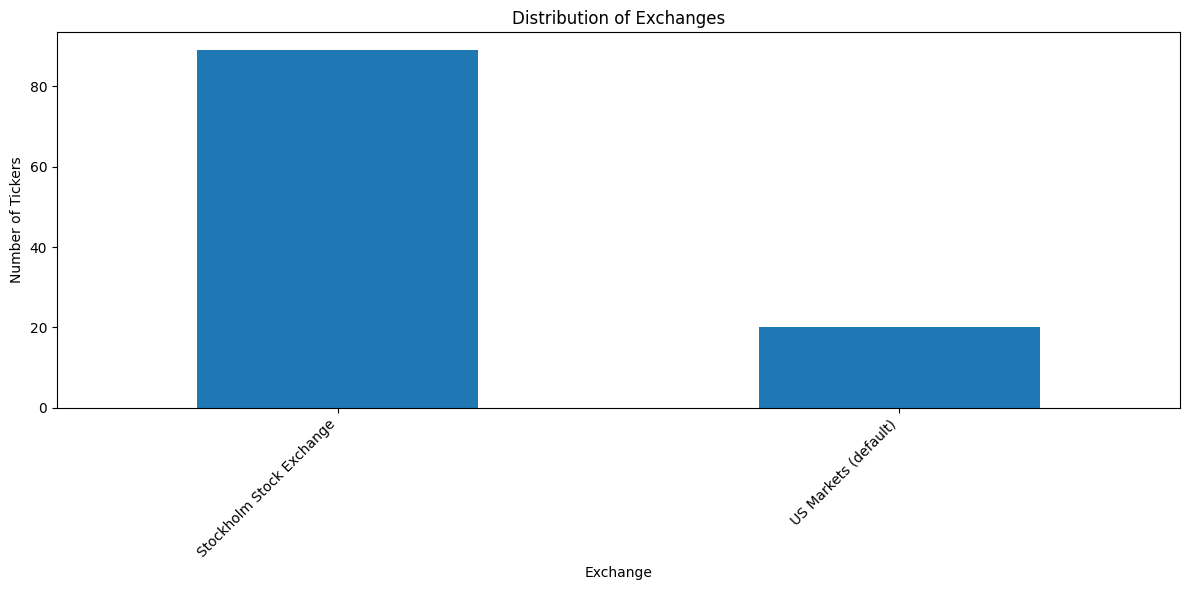

In [50]:
# Generate summary of which exchanges were found
exchange_counts = all_results_df['Exchange'].value_counts()
print("Exchange distribution:")
display(exchange_counts)

# Plot the exchange distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
exchange_counts.plot(kind='bar')
plt.title('Distribution of Exchanges')
plt.xlabel('Exchange')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Handle Tickers Not Found

In [51]:
# Extract tickers that were not found
not_found = all_results_df[all_results_df['YahooTicker'].isna()]

if len(not_found) > 0:
    print(f"The following {len(not_found)} tickers were not found on Yahoo Finance:")
    display(not_found[['OriginalTicker', 'CleanedTicker']])
    
    # Save not found tickers to a separate file for manual investigation
    not_found_file = 'not_found_tickers.csv'
    not_found.to_csv(not_found_file, index=False)
    print(f"Not found tickers saved to {not_found_file}")
else:
    print("All tickers were successfully found on Yahoo Finance!")

All tickers were successfully found on Yahoo Finance!
